# MILESTONE 3

In [179]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tqdm import tqdm
from livelossplot import PlotLosses
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle("data.pkl")
# Transfer the columns into approreate type
df.Bid = df.Bid.str.replace(",","").astype('float64')
df.Date = pd.to_datetime(df.Date)
df

# Drop the redundant columns and get dummies for categories columns
clean_df = pd.get_dummies(df.drop(["Year-Month Bid For", "Date"], axis=1), columns=["Company","Month","Week","Train_Type"], drop_first=True)
clean_df
df.columns

Index(['Date', 'Week', 'Month', 'Year', 'Company', 'Month Bid For',
       'Year Bid For', 'Near-Month Indicator', 'Train_Type', 'Bid',
       'Year-Month Bid For'],
      dtype='object')

In [3]:
clean_df.columns

Index(['Year', 'Month Bid For', 'Year Bid For', 'Near-Month Indicator', 'Bid',
       'Company_CPKC', 'Company_UP', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10',
       'Month_11', 'Month_12', 'Week_2', 'Week_3', 'Week_4', 'Week_5',
       'Week_6', 'Week_7', 'Week_8', 'Week_9', 'Week_10', 'Week_11', 'Week_12',
       'Week_13', 'Week_14', 'Week_15', 'Week_16', 'Week_17', 'Week_18',
       'Week_19', 'Week_20', 'Week_21', 'Week_22', 'Week_23', 'Week_24',
       'Week_25', 'Week_26', 'Week_27', 'Week_28', 'Week_29', 'Week_30',
       'Week_31', 'Week_32', 'Week_33', 'Week_34', 'Week_35', 'Week_36',
       'Week_37', 'Week_38', 'Week_39', 'Week_40', 'Week_41', 'Week_42',
       'Week_43', 'Week_44', 'Week_45', 'Week_46', 'Week_47', 'Week_48',
       'Week_49', 'Week_50', 'Week_51', 'Week_52', 'Week_53',
       'Train_Type_Shuttle'],
      dtype='object')

In [4]:
clean_df.head()

,Year,Month Bid For,Year Bid For,Near-Month Indicator,Bid,Company_CPKC,Company_UP,Month_2,Month_3,Month_4,...,Week_45,Week_46,Week_47,Week_48,Week_49,Week_50,Week_51,Week_52,Week_53,Train_Type_Shuttle
0,1997,5,1997,True,-95.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1997,8,1997,False,0.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1997,5,1997,True,-28.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1997,8,1997,False,2.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1997,5,1997,True,-83.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# 3 Layer NN

## Without Batch

In [68]:
df = clean_df.copy()
for col in df.select_dtypes("bool"):
    df[col] = df[col].astype(int)
clean_df = df.copy()

### Testing Different Optimizers

In [ ]:
df = clean_df.copy()
for c in df.select_dtypes("bool"):
    df[c] = df[c].astype(int)

X_np = df.drop("Bid", axis=1).values.astype(np.float32)
y_np = df["Bid"].values.astype(np.float32).reshape(-1, 1)

X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)
class RailCarBidPredictor(nn.Module):
    def __init__(self, input_dim, h1=64, h2=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, 1),
        )
    def forward(self, x):
        return self.net(x)

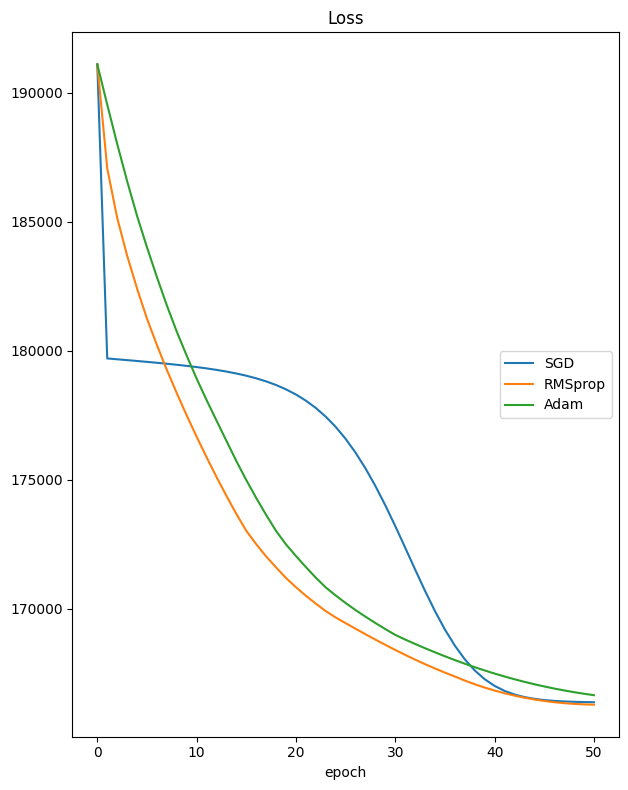

100%|██████████| 2500/2500 [00:12<00:00, 195.62it/s]

Loss
	SGD              	 (min: 166382.609, max: 191097.031, cur: 166382.609)
	RMSprop          	 (min: 166286.125, max: 191097.031, cur: 166286.125)
	Adam             	 (min: 166654.766, max: 191097.031, cur: 166654.766)
[SGD] device=cuda  MSE=165253.281250  R2=-0.000033
[RMSprop] device=cuda  MSE=165160.828125  R2=0.000526
[Adam] device=cuda  MSE=165496.062500  R2=-0.001502


In [70]:
criterion = nn.MSELoss()
epochs = 2500

lr = 1e-5
models = {
    "SGD": {
        "model": RailCarBidPredictor(X_train.shape[1]),                 # model instance for SGD
        "optimizer": lambda params: torch.optim.SGD(params, lr=lr)
    },
    "RMSprop": {
        "model": RailCarBidPredictor(X_train.shape[1]),                 # model instance for RMSprop
        "optimizer": lambda params: torch.optim.RMSprop(params, lr=lr)
    },
    "Adam": {
        "model": RailCarBidPredictor(X_train.shape[1]),                 # model instance for Adam
        "optimizer": lambda params: torch.optim.Adam(params, lr=lr, weight_decay=1e-5)
    }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(67)
if device.type == "cuda":
    torch.cuda.manual_seed_all(67)

initial_model = RailCarBidPredictor(X_train.shape[1])
initial_state_dict = initial_model.state_dict()

for optimizer_name, config in models.items():
    config["optimizer_instance"] = config["optimizer"](config["model"].parameters())
    config["model"].load_state_dict(initial_state_dict)
    config["model"].to(device)
    config["model"].train()

# Live plotting setup (one line per optimizer)
live_plot = PlotLosses(groups={"Loss": [optimizer_name for optimizer_name in models.keys()]})
logs = {}

X_tr = X_train.to(device)
y_tr = y_train.to(device)
X_te = X_test.to(device)
y_te = y_test.to(device)

error = False

# Plot initial loss
for optimizer_name, config in models.items():
    with torch.no_grad():
        y_pred = config["model"](X_tr)
        loss = criterion(y_pred, y_tr)
    logs[optimizer_name] = loss.item()
live_plot.update(logs)
live_plot.send()

# Training loop
for epoch in tqdm(range(epochs)):
    if error:
        break

    for optimizer_name, config in models.items():
        config["optimizer_instance"].zero_grad()

        y_pred = config["model"](X_tr)
        loss = criterion(y_pred, y_tr)

        if not torch.isfinite(loss):
            print(f"[{optimizer_name}] Non-finite loss at epoch {epoch+1}: {loss.item()}")
            print(f"Model: {config['model']}")
            print(f"Optimizer: {config['optimizer_instance']}")
            print(f"y_pred: {y_pred}")
            print(f"y_tr: {y_tr}")
            error = True
            break  # stop training this epoch for safety

        loss.backward()
        config["optimizer_instance"].step()

        logs[optimizer_name] = loss.item()

    # Update live plot periodically (every 50 epochs)
    if (epoch + 1) % 50 == 0:
        live_plot.update(logs)
        live_plot.send()

# Switch all models to evaluation mode and compute test metrics
for optimizer_name, config in models.items():
    config["model"].eval()

    with torch.no_grad():
        y_pred_test = config["model"](X_te).cpu().numpy()
    y_true = y_te.cpu().numpy()

    mse  = mean_squared_error(y_true, y_pred_test)
    r2   = r2_score(y_true, y_pred_test)
    print(f"[{optimizer_name}] device={device}  MSE={mse:.6f}  R2={r2:.6f}")


Choosing RMSProp Optimizer because it seems to converge the fastest to a minima

## Mini-Batch Training Speed Comparison

In [117]:
np.average(np.abs(np.diff([float("inf"),2,3,2,3,6,1]))[-5:])

np.float64(2.2)

In [ ]:
batch_sizes = [512, 256, 128, 64, 32, 16]
lr = 1e-3

X_train, X_val_test, y_train, y_val_test = train_test_split(
    X_np, y_np, test_size=0.4, random_state=67
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=67
)

x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train).astype(np.float32)
X_val  = x_scaler.transform(X_val).astype(np.float32)

train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds  = TensorDataset(torch.from_numpy(X_val),  torch.from_numpy(y_val))

loaders = {}
for batch_size in batch_sizes:
    loaders[batch_size] = {
        "train_loader": DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False),
        "val_loader": DataLoader(val_ds,  batch_size=batch_size, shuffle=False, drop_last=False)
    }

minibatch_model = RailCarBidPredictor(X_train.shape[1])
minibatch_model.load_state_dict(initial_state_dict)
minibatch_model.to(device)
minibatch_optimizer = torch.optim.RMSprop(minibatch_model.parameters(), lr=lr)

minibatch_stats = {batch_size: {} for batch_size in batch_sizes}

convergence_threshold = 10
convergence_window = 100

for batch_size in batch_sizes:
    minibatch_stats[batch_size]["epoch_losses"] = []    

    train_loader = loaders[batch_size]["train_loader"]
    val_loader = loaders[batch_size]["val_loader"]

    minibatch_model.train()
    train_start_time = time.time()
    pbar = tqdm(range(1, epochs + 1))
    for epoch in pbar:
        avg_loss_diff = np.average(
            -np.diff(
                minibatch_stats[batch_size]["epoch_losses"]
            )[-convergence_window:]
        )

        if len(minibatch_stats[batch_size]["epoch_losses"]) > convergence_window and avg_loss_diff < convergence_threshold:
            minibatch_stats[batch_size]["epoch_converged"] = epoch
            minibatch_stats[batch_size]["training_duration"] = time.time() - train_start_time
            break

        epoch_loss = 0.0
        
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            minibatch_optimizer.zero_grad()
            preds = minibatch_model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            minibatch_optimizer.step()

            epoch_loss += loss.item() * xb.size(0)

        epoch_loss /= len(train_loader.dataset)
        minibatch_stats[batch_size]["epoch_losses"].append(epoch_loss)
        pbar.set_postfix({"batch_size": batch_size, "average_delta_loss": avg_loss_diff})
    
    minibatch_model.eval()
    with torch.no_grad():
        y_pred_list = []
        for xb, _ in val_loader:
            xb = xb.to(device)
            preds = minibatch_model(xb).cpu().numpy()
            y_pred_list.append(preds)
        y_pred = np.vstack(y_pred_list).reshape(-1)

    y_true = y_val.reshape(-1)

    mse  = mean_squared_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    minibatch_stats[batch_size]["val_mse"] = mse
    minibatch_stats[batch_size]["val_r2"]  = r2

    print(f"[Batch Size={batch_size}] device={device}  MSE={mse:.6f}  R2={r2:.6f}, Training Time={minibatch_stats[batch_size]["training_duration"]:.2f}s")

    minibatch_model.load_state_dict(initial_state_dict)  # Reset model weights for next batch size

  0%|          | 0/2500 [00:00<?, ?it/s]c:\Users\FalseStatement\Downloads\IE434_DeepDive_Group1-20251210T021634Z-3-001\IE434_DeepDive_Group1\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:571: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\FalseStatement\Downloads\IE434_DeepDive_Group1-20251210T021634Z-3-001\IE434_DeepDive_Group1\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 73%|███████▎  | 1821/2500 [02:48<01:02, 10.78it/s, batch_size=512, average_delta_loss=14.8] 


[Batch Size=512] device=cuda  MSE=163753.578125  R2=-0.002403, Training Time=168.96s


  0%|          | 0/2500 [00:00<?, ?it/s]c:\Users\FalseStatement\Downloads\IE434_DeepDive_Group1-20251210T021634Z-3-001\IE434_DeepDive_Group1\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:571: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\FalseStatement\Downloads\IE434_DeepDive_Group1-20251210T021634Z-3-001\IE434_DeepDive_Group1\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  1%|          | 19/2500 [00:02<05:09,  8.03it/s, batch_size=256, average_delta_loss=1.03e+3]


KeyboardInterrupt: 

In [167]:
minibatch_stats[512].keys()

dict_keys(['epoch_losses', 'epoch_converged', 'training_duration', 'val_mse', 'val_r2'])

In [145]:
import pickle

with open("minibatch_stats.pkl", "wb") as out_pkl:
    pickle.dump(minibatch_stats, out_pkl)

<Axes: >

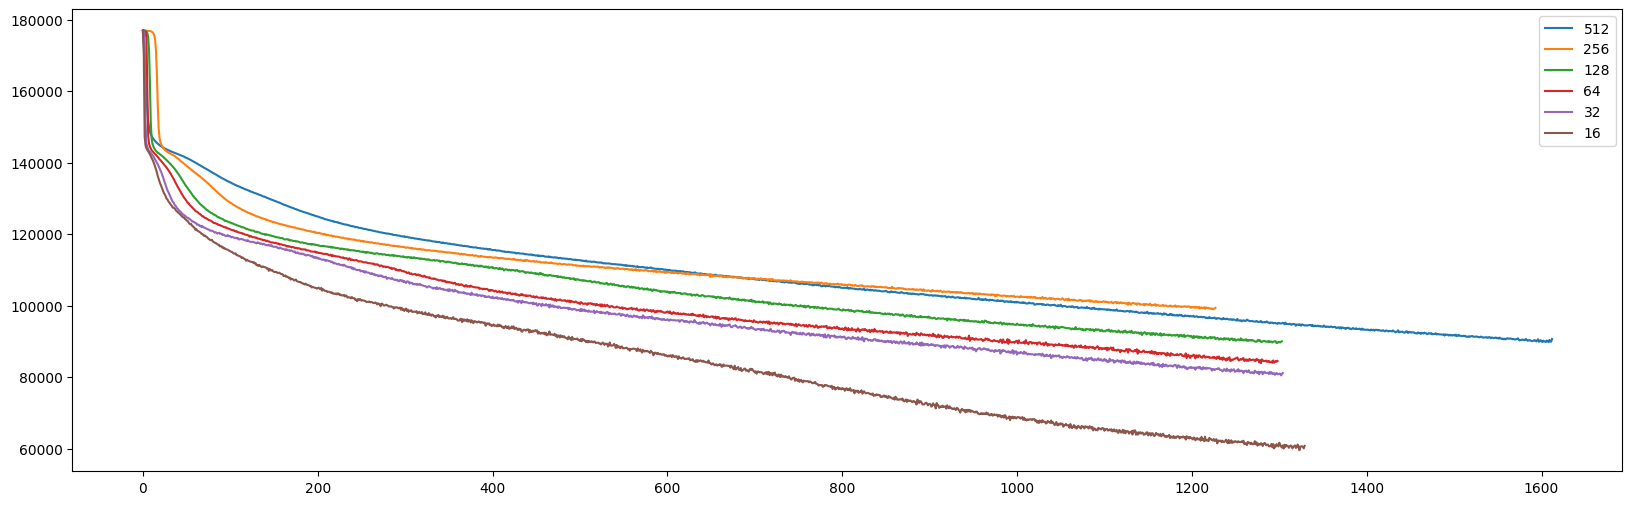

In [150]:
max_len = max([len(v["epoch_losses"]) for v in minibatch_stats.values()])
convergence_df = pd.DataFrame({k: np.pad(v["epoch_losses"], (0, max_len - len(v["epoch_losses"])), constant_values=np.nan) for k, v in minibatch_stats.items()})

convergence_df.plot(figsize=(20,6))

In [157]:
[batch["training_duration"] for batch_size in batch_sizes if (batch := minibatch_stats[batch_size])]

[99.21368932723999,
 102.10496807098389,
 174.1279580593109,
 321.416855096817,
 556.5102572441101,
 1093.7290661334991]

<Axes: >

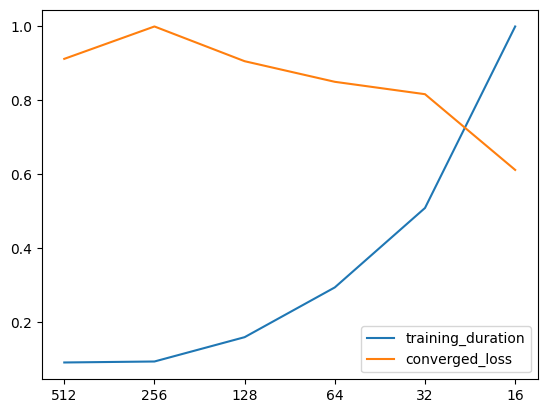

In [162]:
durations = [batch["training_duration"] for batch_size in batch_sizes if (batch := minibatch_stats[batch_size])]
end_loss = [batch["epoch_losses"][-1] for batch_size in batch_sizes if (batch := minibatch_stats[batch_size])]

durations = np.array(durations) / np.max(durations)
end_loss = np.array(end_loss) / np.max(end_loss)

stats_df = pd.DataFrame({
    "training_duration": durations,
    "converged_loss": end_loss
}, index=[f"{batch_size}" for batch_size in batch_sizes])

stats_df.plot()

Seems like the optimal tradeoff between comptue time and loss is around 24, which is what we will use in the final model

## HYPERPARAMETERS TUNING

In [202]:
def test_hyperparameters(lrs, hidden1s, hidden2s, epochs, train_loader, val_loader):
    hyperparam_stats = {}
    for lr in lrs:
        hyperparam_stats[lr] = {}
        for h1 in hidden1s:
            hyperparam_stats[lr][h1] = {}
            for h2 in hidden2s:
                hyperparam_stats[lr][h1][h2] = {}
                hyperparam_model = RailCarBidPredictor(X_train.shape[1], h1, h2)
                hyperparam_model.to(device)
                optimizer = torch.optim.RMSprop(hyperparam_model.parameters(), lr=lr)

                min_loss = float("inf")

                hyperparam_model.train()
                pbar = tqdm(range(1, epochs + 1))
                for epoch in pbar:
                    epoch_loss = 0.0
                    for xb, yb in train_loader:
                        xb = xb.to(device)
                        yb = yb.to(device)
                        
                        optimizer.zero_grad()
                        y_pred = hyperparam_model(xb)
                        loss = criterion(y_pred, yb)
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item() * xb.size(0)
                    epoch_loss /= len(train_loader.dataset)
                    min_loss = min((min_loss, epoch_loss))

                    pbar.set_postfix({"min_loss": min_loss})

                
                hyperparam_model.eval()
                with torch.no_grad():
                    y_pred_list = []
                    for xb, _ in val_loader:
                        xb = xb.to(device)
                        preds = hyperparam_model(xb).cpu().numpy()
                        y_pred_list.append(preds)
                    y_pred = np.vstack(y_pred_list).reshape(-1)

                y_true = y_val.reshape(-1)

                mse  = mean_squared_error(y_true, y_pred)
                r2   = r2_score(y_true, y_pred)

                print(f"{lr=}, {h1=}, {h2=} | {mse=}, {r2=}")

                hyperparam_stats[lr][h1][h2]["val_mse"] = mse
                hyperparam_stats[lr][h1][h2]["val_r2"]  = r2
                hyperparam_stats[lr][h1][h2]["min_training_loss"] = min_loss
    
    return hyperparam_stats
            

In [204]:
lrs = [1e-1, 1e-2, 1e-3]
hidden1s = [128, 256, 512]
hidden2s = [128, 256, 512]

# Use maximum batch size for speed
train_loader = loaders[512]["train_loader"]
val_loader = loaders[512]["val_loader"]

hyperparams_test1_stats = test_hyperparameters(
    lrs=lrs,
    hidden1s=hidden1s,
    hidden2s=hidden2s,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=1000
)

100%|██████████| 1000/1000 [00:56<00:00, 17.86it/s, min_loss=2.68e+4]


lr=0.1, h1=128, h2=128 | mse=202295.3125, r2=-0.23833274841308594


100%|██████████| 1000/1000 [00:56<00:00, 17.58it/s, min_loss=2.77e+4]


lr=0.1, h1=128, h2=256 | mse=191004.109375, r2=-0.16921472549438477


100%|██████████| 1000/1000 [01:04<00:00, 15.40it/s, min_loss=2.36e+4]


lr=0.1, h1=128, h2=512 | mse=150613.890625, r2=0.07803040742874146


100%|██████████| 1000/1000 [01:05<00:00, 15.19it/s, min_loss=2.43e+4]


lr=0.1, h1=256, h2=128 | mse=192070.46875, r2=-0.17574238777160645


100%|██████████| 1000/1000 [01:12<00:00, 13.73it/s, min_loss=2.65e+4]


lr=0.1, h1=256, h2=256 | mse=169109.328125, r2=-0.035187721252441406


100%|██████████| 1000/1000 [01:08<00:00, 14.59it/s, min_loss=2.66e+4]


lr=0.1, h1=256, h2=512 | mse=167457.9375, r2=-0.025078892707824707


100%|██████████| 1000/1000 [01:01<00:00, 16.20it/s, min_loss=3.01e+4]


lr=0.1, h1=512, h2=128 | mse=189155.25, r2=-0.15789711475372314


100%|██████████| 1000/1000 [01:01<00:00, 16.36it/s, min_loss=3.12e+4]


lr=0.1, h1=512, h2=256 | mse=192534.984375, r2=-0.17858576774597168


100%|██████████| 1000/1000 [01:02<00:00, 16.04it/s, min_loss=2.97e+4]


lr=0.1, h1=512, h2=512 | mse=178914.328125, r2=-0.09520816802978516


100%|██████████| 1000/1000 [01:02<00:00, 16.00it/s, min_loss=1.11e+4]


lr=0.01, h1=128, h2=128 | mse=147331.609375, r2=0.09812259674072266


100%|██████████| 1000/1000 [01:02<00:00, 15.98it/s, min_loss=9.56e+3]


lr=0.01, h1=128, h2=256 | mse=160932.578125, r2=0.014865458011627197


100%|██████████| 1000/1000 [01:03<00:00, 15.84it/s, min_loss=7.78e+3]


lr=0.01, h1=128, h2=512 | mse=161426.78125, r2=0.011840283870697021


100%|██████████| 1000/1000 [00:59<00:00, 16.75it/s, min_loss=9.22e+3]


lr=0.01, h1=256, h2=128 | mse=151517.546875, r2=0.07249879837036133


100%|██████████| 1000/1000 [01:00<00:00, 16.54it/s, min_loss=7.28e+3]


lr=0.01, h1=256, h2=256 | mse=163824.609375, r2=-0.0028377771377563477


100%|██████████| 1000/1000 [01:00<00:00, 16.43it/s, min_loss=5.84e+3]


lr=0.01, h1=256, h2=512 | mse=130356.59375, r2=0.20203369855880737


100%|██████████| 1000/1000 [01:02<00:00, 16.08it/s, min_loss=8.48e+3]


lr=0.01, h1=512, h2=128 | mse=141103.078125, r2=0.1362500786781311


100%|██████████| 1000/1000 [01:00<00:00, 16.43it/s, min_loss=6.19e+3]


lr=0.01, h1=512, h2=256 | mse=147312.15625, r2=0.09824162721633911


100%|██████████| 1000/1000 [01:00<00:00, 16.41it/s, min_loss=4.39e+3]


lr=0.01, h1=512, h2=512 | mse=134631.171875, r2=0.1758671998977661


100%|██████████| 1000/1000 [01:03<00:00, 15.79it/s, min_loss=8.04e+4]


lr=0.001, h1=128, h2=128 | mse=140353.578125, r2=0.14083796739578247


100%|██████████| 1000/1000 [01:07<00:00, 14.91it/s, min_loss=8.26e+4]


lr=0.001, h1=128, h2=256 | mse=142993.953125, r2=0.12467515468597412


100%|██████████| 1000/1000 [01:03<00:00, 15.71it/s, min_loss=5.89e+4]


lr=0.001, h1=128, h2=512 | mse=132349.296875, r2=0.1898355484008789


100%|██████████| 1000/1000 [01:07<00:00, 14.87it/s, min_loss=7.92e+4]


lr=0.001, h1=256, h2=128 | mse=139990.6875, r2=0.1430593729019165


100%|██████████| 1000/1000 [01:05<00:00, 15.37it/s, min_loss=8.07e+4]


lr=0.001, h1=256, h2=256 | mse=146990.59375, r2=0.10021013021469116


100%|██████████| 1000/1000 [01:05<00:00, 15.32it/s, min_loss=6.27e+4]


lr=0.001, h1=256, h2=512 | mse=146498.34375, r2=0.10322338342666626


100%|██████████| 1000/1000 [01:05<00:00, 15.38it/s, min_loss=7.65e+4]


lr=0.001, h1=512, h2=128 | mse=144974.109375, r2=0.11255389451980591


100%|██████████| 1000/1000 [01:04<00:00, 15.42it/s, min_loss=7.2e+4]


lr=0.001, h1=512, h2=256 | mse=156372.015625, r2=0.04278254508972168


100%|██████████| 1000/1000 [01:05<00:00, 15.37it/s, min_loss=4.9e+4]

lr=0.001, h1=512, h2=512 | mse=149483.90625, r2=0.08494752645492554


In [205]:
with open("hyperparam_1_stats.pkl", "wb") as out_pkl:
    pickle.dump(hyperparams_test1_stats, out_pkl)

130356.59375 202295.3125


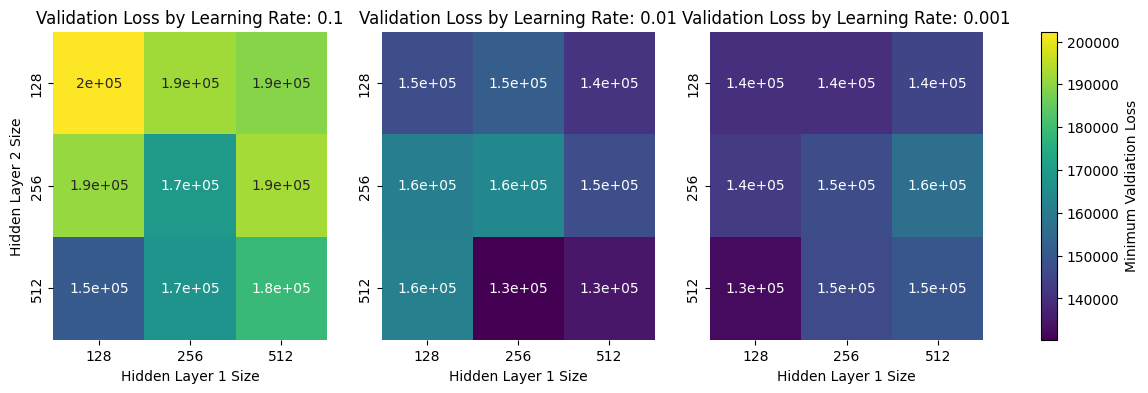

In [211]:
fig, axes = plt.subplots(1, len(lrs), figsize=(5 * len(lrs), 4))

all_vals = [
    hyperparams_test1_stats[lr][h1][h2]["val_mse"]
    for lr in lrs
    for h1 in hidden1s
    for h2 in hidden2s
]

vmin = np.min(all_vals)
vmax = np.max(all_vals)

print(vmin, vmax)

for i, (ax, lr) in enumerate(zip(axes, lrs)):
    lr_stats = {}
    for h1 in hidden1s:
        lr_stats[h1] = []
        for h2 in hidden2s:
            lr_stats[h1].append(hyperparams_test1_stats[lr][h1][h2]["val_mse"])
    
    lr_stats_df = pd.DataFrame(lr_stats, index=hidden2s)
    sns.heatmap(lr_stats_df, annot=True, ax=ax, vmax=vmax, vmin=vmin, cbar=False, norm=plt.Normalize(vmax=vmax, vmin=vmin), cmap="viridis")
    ax.set_title(f"Validation Loss by Learning Rate: {lr}")
    if i == 0:
        ax.set_ylabel("Hidden Layer 2 Size")
    
    ax.set_xlabel("Hidden Layer 1 Size")

fig.colorbar(
    plt.cm.ScalarMappable(norm=plt.Normalize(vmax=vmax, vmin=vmin), cmap="viridis"),
    ax=axes,
    location='right',
    label="Minimum Valdiation Loss",
)

plt.show()

We choose the learning rate, batch size and layers in hidden1 and hidden2. The top models always with the higher learning rate and the smaller batch size might has better result. We try to use higher learning rate in following cells to test the hypothesis about learning rate.

In [251]:
# Best params found
lr = 0.01
h1 = 256
h2 = 512

epochs = 200
batch_size = 24

model = RailCarBidPredictor(X_train.shape[1], h1, h2)
model.to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

X_train_full = np.concat((X_train, X_val))
X_train_full = x_scaler.fit_transform(X_train_full).astype(np.float32)
X_test = x_scaler.fit_transform(X_test).astype(np.float32)

y_train_full = np.concat((y_train, y_val))

train_ds = TensorDataset(torch.from_numpy(X_train_full), torch.from_numpy(y_train_full))
test_ds  = TensorDataset(torch.from_numpy(X_test),  torch.from_numpy(y_test))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False)

liveloss_plot = PlotLosses(figsize=(20, 5))
logs = {}

Setting figsize to (20, 5)


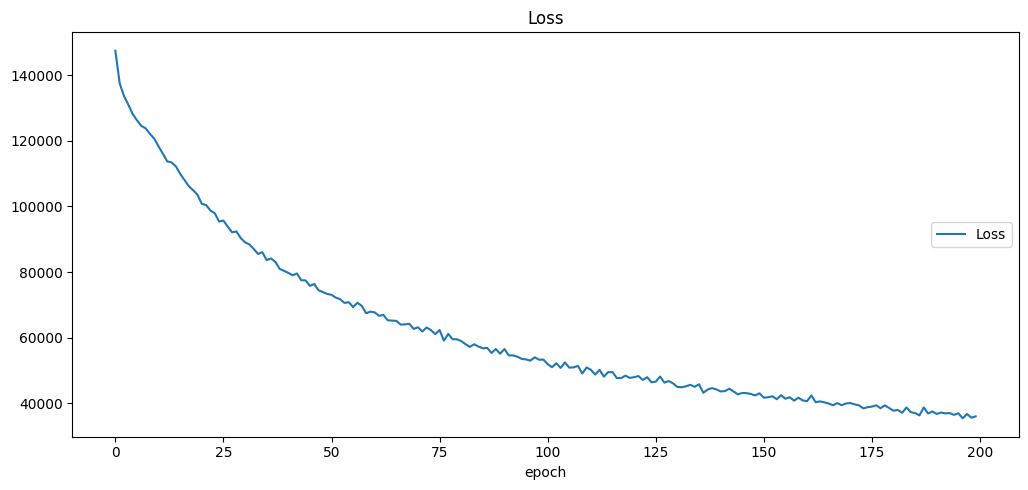

100%|██████████| 200/200 [02:41<00:00,  1.24it/s, epoch_loss=3.61e+4]

Loss
	Loss             	 (min: 35477.503, max: 147445.421, cur: 36072.936)


In [252]:
pbar = tqdm(range(epochs))
model.train()
for epoch in pbar:
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        y_pred = model(xb)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_loader.dataset)

    logs["Loss"] = epoch_loss
    liveloss_plot.update(logs)
    liveloss_plot.send()
    pbar.set_postfix({"epoch_loss": epoch_loss})

We found the best parameters group is lr = 0.01	batch_size = 16, hidden1 = 64, hidden2 = 16
## Testing Best Model

In [249]:
torch.save(model.state_dict(), "best_model.pth")

In [254]:
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [255]:
model.eval()
with torch.no_grad():
    y_pred_list = []
    for xb, _ in test_loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        y_pred_list.append(preds)
    y_pred = np.vstack(y_pred_list).reshape(-1)

y_true = y_test.reshape(-1)

mse  = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print(f"MSE: {mse}, R2: {r2}")

MSE: 471819.21875, R2: -1.6701133251190186


ai usage: USE CHATGPT AND CLAUDE TO GENERATE THE NN FRAMEWORK